In [1]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.eager as tfe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
tf.enable_eager_execution()

In [3]:
import tensorflow as tf
tf_config=tf.ConfigProto()
tf_config.gpu_options.allow_growth=True
sess = tf.Session(config=tf_config)
import random

In [4]:

tf.__version__

'1.15.0'

In [5]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [6]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [7]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [8]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [9]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [11]:
x_train.shape

(50000, 40, 40, 3)

In [13]:
IMAGE_HEIGHT = 40
IMAGE_WIDTH = 40
IMAGE_DEPTH = 3
NUM_CLASSES = 10
# Type convertion functions
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# convert images to tfrecords

def _convert_to_tfrecord(data, labels, tfrecords_filename):
  """Converts a file to TFRecords."""
  print('Generating %s' % tfrecords_filename)
  with tf.python_io.TFRecordWriter(tfrecords_filename) as record_writer:
    num_entries_in_batch = len(labels)
    for i in range(num_entries_in_batch):
      example = tf.train.Example(features=tf.train.Features(
        feature={
          'image': _bytes_feature(data[i].tobytes()),
          'label': _int64_feature(labels[i])
        }))
      record_writer.write(example.SerializeToString())


train_tfrecords_filename = 'TrainCifar10.tfrecords'
test_tfrecords_filename = 'TestCifar10.tfrecords'

_convert_to_tfrecord(x_train, y_train,train_tfrecords_filename)
_convert_to_tfrecord(x_test,y_test,test_tfrecords_filename)

Generating TrainCifar10.tfrecords
Generating TestCifar10.tfrecords


In [14]:
# parsing the tf-record stored
def parse_record(serialized_example, isTraining = True):
  features = tf.parse_single_example(
    serialized_example,
    features={
      'image': tf.FixedLenFeature([], tf.string),
      'label': tf.FixedLenFeature([], tf.int64),
    })

  image = features['image']
  # decoding image data in bytes format to array
  image = tf.decode_raw(image, tf.float32)
  # reshape the image from linear list to image shape
  if(isTraining):
    image.set_shape([IMAGE_DEPTH * IMAGE_HEIGHT * IMAGE_WIDTH])
    image = tf.reshape(image, [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
  else:
    image.set_shape([IMAGE_DEPTH * 32 * 32])
    image = tf.reshape(image, [32, 32, IMAGE_DEPTH])
  
  #casting label data to integer format
  label = tf.cast(features['label'], tf.int64)

  return image, label

def get_decoded_records(file_name, isTraining = True):
  # returns list of tuples each containing image and label
  dataset = tf.data.TFRecordDataset(filenames=file_name)
  dataset = dataset.map(lambda x: parse_record(x, isTraining))
  return dataset

In [184]:
def random_erasing(img, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3):
    '''
    img is a 3-D variable (ex: tf.Variable(image, validate_shape=False) ) and  HWC order
    '''
    # HWC order
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]
    channel = tf.shape(img)[2]
    area = tf.cast(width*height, tf.float32)

    erase_area_low_bound = tf.cast(tf.round(tf.sqrt(sl * area * r1)), tf.int32)
    erase_area_up_bound = tf.cast(tf.round(tf.sqrt((sh * area) / r1)), tf.int32)
    h_upper_bound = tf.minimum(erase_area_up_bound, height)
    w_upper_bound = tf.minimum(erase_area_up_bound, width)

    h = tf.random.uniform([], erase_area_low_bound, h_upper_bound, tf.int32)
    w = tf.random.uniform([], erase_area_low_bound, w_upper_bound, tf.int32)
    h=12
    w=12
    x1 = tf.random.uniform([], 0, height+1 - h, tf.int32)
    y1 = tf.random.uniform([], 0, width+1 - w, tf.int32)
    
    test1 = tf.Variable(tf.zeros(shape=(40,40,1),dtype = tf.int32))
    test2 = tf.Variable(tf.zeros(shape=(40,40,1),dtype = tf.int32))
    test3 = tf.Variable(tf.zeros(shape=(40,40,1),dtype = tf.int32))
    
    
    erase_area = tf.cast(tf.random.uniform([h, w, channel], 0, 255, tf.int32), tf.int8)
    paddings = tf.constant([[14, 14], [14, 14]])
#     erase_area = erase_area[:,:,1]
#     paddings = tf.constant([[14, 14], [14, 14]])
    test1 = tf.pad(erase_area[:,:,0],paddings,"CONSTANT")
    test2 = tf.pad(erase_area[:,:,1],paddings,"CONSTANT")
    test3 = tf.pad(erase_area[:,:,2],paddings,"CONSTANT")
#     print(test1.shape)
#     tf.stack([r,g,b], axis=2)
    test = tf.stack([test1,test2,test3],axis=2)
#     print(test.shape)
#     return(test)
#     print(erase_area.shape)
#     print(img.shape)
    erasing_img1 = tf.add(tf.cast(test1,tf.float32),tf.cast(img[:,:,0],tf.float32))
    erasing_img2 = tf.add(tf.cast(test2,tf.float32),tf.cast(img[:,:,1],tf.float32))
    erasing_img3 = tf.add(tf.cast(test3,tf.float32),tf.cast(img[:,:,2],tf.float32))
    erasing_img = tf.stack([erasing_img1,erasing_img2,erasing_img3],axis=2)
    return(erasing_img)
    erasing_img = img[x1:x1+h, y1:y1+w, :].assign(erase_area)
    print(erasing_img.shape)
    return(erasing_img)

#     return tf.cond(tf.random.uniform([], 0, 1) > probability, lambda: img, lambda: erasing_img)

In [185]:
x = get_decoded_records('TrainCifar10.tfrecords', isTraining = True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'tensorflow.python.framework.ops.EagerTensor'>


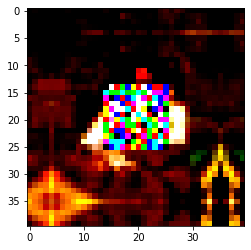

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 6
<class 'tensorflow.python.framework.ops.EagerTensor'>


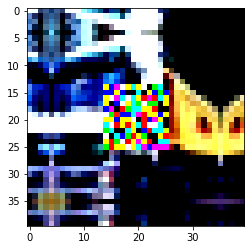

Label: 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'tensorflow.python.framework.ops.EagerTensor'>


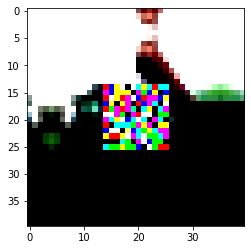

Label: 9


In [193]:
mnist_example = x.take(3)
for sample in mnist_example:
    image, label = sample[0], sample[1].numpy()
    image = random_erasing(image,probability=0.1)
    print(type(image))
#     image = image.numpy()
    plt.imshow(image.numpy().astype(np.float32), cmap=plt.get_cmap("gray"))
    plt.show()

    print("Label: %d" % label)

In [192]:
tf.assign

<function tensorflow.python.ops.state_ops.assign(ref, value, validate_shape=None, use_locking=None, name=None)>

In [ ]:
input_array = np.array([2, 4, 7, 11, 3, 8, 9, 19, 11, 7])
inplace_array = np.array([10, 20])
indices_array = np.array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0])
# [[2], [6]] 
indices = tf.cast(tf.where(tf.equal(indices_array, 1)), tf.int32)
# [0, 0, 10, 0, 0, 0, 20, 0, 0, 0]
scatter = tf.scatter_nd(indices, inplace_array, shape=tf.shape(input_array))
# [1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
inverse_mask = tf.cast(tf.math.logical_not(indices_array), tf.int32)
# [2, 4, 0, 11, 3, 8, 0, 19, 11, 7]
input_array_zero_out = tf.multiply(inverse_mask, input_array)
# [2, 4, 10, 11, 3, 8, 20, 19, 11, 7]
output = tf.add(input_array_zero_out, tf.cast(scatter, tf.int32))

In [194]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
# data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
data_aug = lambda x, y: (random_erasing(x), y)

In [195]:
t = time.time()
test_set = get_decoded_records(test_tfrecords_filename, isTraining=False).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = get_decoded_records(train_tfrecords_filename).map(data_aug).shuffle(len_train).\
    batch(BATCH_SIZE).prefetch(1)
  tf.keras.backend.set_learning_phase(1)

  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)

ValueError: in converted code:

    <ipython-input-176-e2185542794a>:9 None  *
        data_aug = lambda x, y: (random_erasing(x), y)
    <ipython-input-184-339e2be13cae>:23 random_erasing  *
        test1 = tf.Variable(tf.zeros(shape=(40,40,1),dtype = tf.int32))
    /home/anuda/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:258 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /home/anuda/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:219 _variable_v1_call
        shape=shape)
    /home/anuda/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:197 <lambda>
        previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
    /home/anuda/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variable_scope.py:2503 default_variable_creator
        shape=shape)
    /home/anuda/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:262 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    /home/anuda/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1406 __init__
        distribute_strategy=distribute_strategy)
    /home/anuda/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1489 _init_from_args
        raise ValueError("Tensor-typed variable initializers must either be "

    ValueError: Tensor-typed variable initializers must either be wrapped in an init_scope or callable (e.g., `tf.Variable(lambda : tf.truncated_normal([10, 40]))`) when building functions. Please file a feature request if this restriction inconveniences you.
